# Ansibleを利用したVCノードの操作

このNotebookではAnsible による VCノードの操作を行ってみます。

## Ansibleについて

[Ansible](https://www.ansible.com/)は構成管理ツールとよばれるもののひとつです。次のような特徴をもっています。

* エージェントレス
 - 管理対象となるホストに専用のエージェントをインストールする必要がない
 - Python が使用可能なこと、sshで接続可能であればよい
* 冪等性
 - 何度操作しても同じ状態になることを保証している
 - ただし、シェルコマンドを実行するモジュールなどの冪等性を保証しないものもある
* モジュール
 - ansibleの特定の機能を行う単位
 - コマンドを実行するモジュールやファイルを操作するモジュールなどがある
 - モジュールのリストは「[All modules](https://docs.ansible.com/ansible/latest/modules/list_of_all_modules.html)」で確認できる

複数のホストに対する操作が容易になるなどの利点があるので、VCPのアプリケーションテンプレートではVCノードを操作するために ansible を利用しています。

## 操作手順

この Notebook では大まかな操作手順は以下のようになります。

1. Ansibleの操作対象となるVCノードを起動する
1. VCノードをAnsibleのインベントリに登録する
1. Ansibleを利用して VCノード でコマンドを実行する
1. Ansibleを利用して VCノード のファイルをローカル環境に取得する
1. Ansibleを利用して VCノード でパッケージをインストールする
1. Ansibleを利用してローカル環境のファイルをVCノードに配置する

# VCノードを起動する

Ansible の操作対象とする VCノード を起動します。

## 構成

２つの VCノードを起動します。Unit, VCノードの構成を次の図に示します。

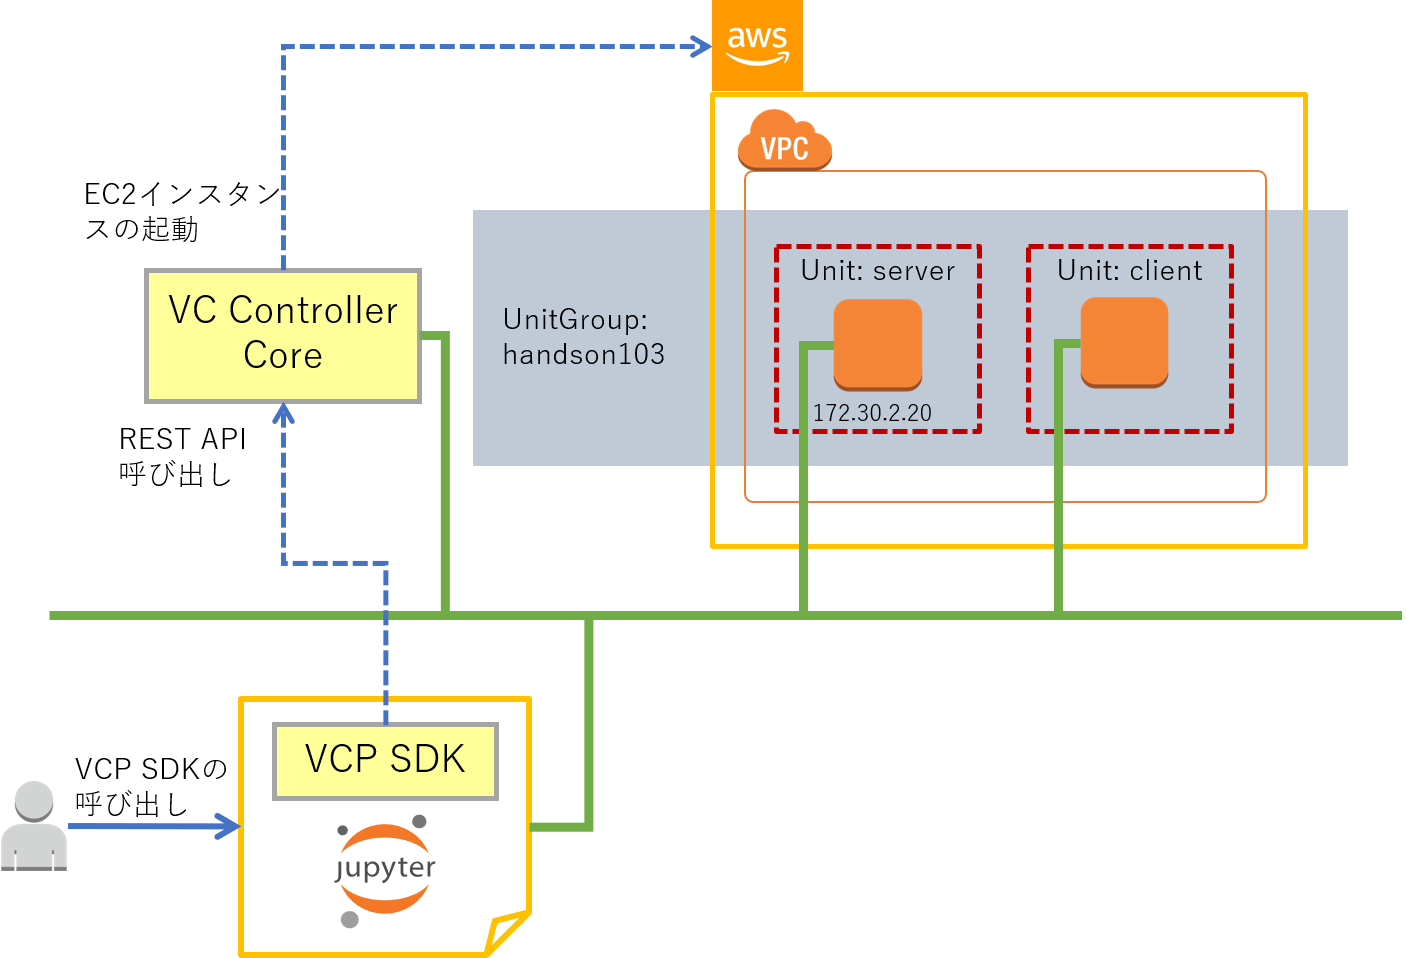

* UnitGroup: handson103
  - Unit: server
    + サーバ用のVCノード
    + 固定のIPアドレスを設定する
    + flavor: small
  - Unit: client
    + クライアント用のVCノード
    + flavor: small


## アクセストークンの入力

VCP SDKを利用するにはVC Controllerのアクセストークンが必要となります。次のセルを実行すると入力枠が表示されるのでアクセストークンの値を入力してください。

In [1]:
from getpass import getpass
vcc_access_token = getpass()

········


## VCP SDKの初期化

VCP SDKの初期化を行います。

In [2]:
from common import logsetting
from vcpsdk.vcpsdk import VcpSDK


# VCP SDKの初期化
vcp = VcpSDK(
    vcc_access_token,  # VCCのアクセストークン
)

上のセルの実行結果がエラーとなり以下のようなメッセージが表示されている場合は、入力されたアクセストークンに誤りがあります。

```
2018-09-XX XX:XX:XX,XXX - ERROR - config vc failed: http_status(403)
2018-09-XX XX:XX:XX,XXX - ERROR - 2018/XX/XX XX:XX:XX UTC: VCPAuthException: xxxxxxx:token lookup is failed: permission denied
```

この場合はアクセストークンの入力からやり直してください。

## ssh公開鍵認証の設定

VCノードに登録する公開鍵認証の**秘密鍵**のパスを次のセルで設定してください。

> 起動する２つのVCノードには、ここで設定したsshの認証鍵を登録します。

In [3]:
import os
ssh_private_key = os.path.expanduser('~/.ssh/id_rsa')

## サーバ用IPアドレスの設定

サーバ用のVCノードに割り当てるIPアドレスを設定します。

> 割り当て可能な IP アドレスの範囲は[VCP Manager Web UI](https://vcpdev.ecloud.nii.ac.jp/vcp/v1/ui/occmgr/menu/occtrs) から取得することができます。

> 172.30.2.1, 172.30.2.200 は他の用途で割り当て済なので、次のセルで指定しないでください。

In [4]:
server_ip_address = '172.30.2.20'

## VCノードの起動

### VCノードのspecを指定する

このNotebookではサーバ用VCノードのUnitとクライアント用VCノードのUnitを作成します。それぞれのUnitに対応する `spec`を指定します。

#### サーバ用 specの指定

サーバ用VCノードのUnitに対応する spec オブジェクト `spec_server` の設定を行います。

In [5]:
# specの取得
spec_server = VcpSDK.get_spec('aws', 'small')

# SSHの鍵ファイルをVCノードの設定パラメータに合わせたフォーマットに変換して spec に設定する
out = !ssh-keygen -y -f {ssh_private_key} | base64 -w 0
b64_ssh_public_key = out[0]
spec_server.params_e = ['AUTHORIZED_KEYS={}'.format(b64_ssh_public_key)]

# IPアドレスの設定
spec_server.ip_address_list = [server_ip_address]

# 設定内容の表示
print(spec_server)


aws
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: vcp/base:1.3
    recovery_mode: none
    params:
        {'e': ['AUTHORIZED_KEYS=c3NoLXJzYSBBQUFBQjNOemFDMXljMkVBQUFBREFRQUJBQUFCQVFDdE5KYjBIWkU0SHR0ZjV3WWhhbkQyR2RBZm9Wc0o2eVZOR3JMOWFUQ040SWtXUGZ1a1ZOOFdUTldldHp4T3cwOXlrZlZqQlFZUG9JOWhzOHYzd2hjaHRqZlFneHEvWTBvTWFLNlQ1bmdybmtMZFd6VFcxSFhhZ3A0SFdBTGtvVGNtQkhUaG9lWitKdGdkbS9ham8ySHVNblhqbHY0Y215WDVQZ3JhdU5IVDZoTEJUc2k2NzBkNWFSTTZLY3B1VVc0RS8xMHF1WklQcXhaMzJvQnFxU2V6c1gzVlV2Nnk2Um1Ldzg3eC9FUU1XVUtlemR3bHJuTWpwY3p0TTRSQzVrc0s1QWp6bC9oY3FaOGVOMjhaanVxM3RPRHNWY05SVHdzajdGWTZjaXVsbFhURndzZHhjNjM5U290VmpwWWNZSUpqWGhZTW1mTkNpdFFRamxaNVNVdUgK'], 'v': []}
    instance_type: m4.large
    volume_size: 20
    volume_type: standard
    volume_id: []
    cloud_image: default
    tags: {}


#### クライアント用 specオブジェクトの設定

クライアント用VCノードのUnitに対応する spec オブジェクト `spec_client` の設定を行います。

In [6]:
# specの取得
spec_client = VcpSDK.get_spec('aws', 'small')

# SSHの鍵ファイルの設定はサーバと同じなので既に変換済みの値をそのまま利用する
spec_client.params_e = ['AUTHORIZED_KEYS={}'.format(b64_ssh_public_key)]

# 設定内容の表示
print(spec_client)


aws
------------------------

    cci_version: "1.0"
    name: 
    description: 
    private_network: default
    num_nodes: 1
    image: vcp/base:1.3
    recovery_mode: none
    params:
        {'e': ['AUTHORIZED_KEYS=c3NoLXJzYSBBQUFBQjNOemFDMXljMkVBQUFBREFRQUJBQUFCQVFDdE5KYjBIWkU0SHR0ZjV3WWhhbkQyR2RBZm9Wc0o2eVZOR3JMOWFUQ040SWtXUGZ1a1ZOOFdUTldldHp4T3cwOXlrZlZqQlFZUG9JOWhzOHYzd2hjaHRqZlFneHEvWTBvTWFLNlQ1bmdybmtMZFd6VFcxSFhhZ3A0SFdBTGtvVGNtQkhUaG9lWitKdGdkbS9ham8ySHVNblhqbHY0Y215WDVQZ3JhdU5IVDZoTEJUc2k2NzBkNWFSTTZLY3B1VVc0RS8xMHF1WklQcXhaMzJvQnFxU2V6c1gzVlV2Nnk2Um1Ldzg3eC9FUU1XVUtlemR3bHJuTWpwY3p0TTRSQzVrc0s1QWp6bC9oY3FaOGVOMjhaanVxM3RPRHNWY05SVHdzajdGWTZjaXVsbFhURndzZHhjNjM5U290VmpwWWNZSUpqWGhZTW1mTkNpdFFRamxaNVNVdUgK'], 'v': []}
    instance_type: m4.large
    volume_size: 20
    volume_type: standard
    volume_id: []
    cloud_image: default
    tags: {}


### UnitGroup, Unitの作成とVCノードの起動

UnitGroup, Unitを作成し、VCノードの起動を行います。

まずUnitGroupを作成します。

In [7]:
unit_group = vcp.create_ugroup(
    'handson103'                 # UnitGroupの名前
)

VCノード起動前のUnit, VCノードの状態を確認しておきます。

In [8]:
from IPython.display import display

# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# Nodeの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state


None

Unitを作成します。Unitを作成すると同時に VCノード（Amazon EC2インスタンス）が起動します。

> 処理が完了するまで3分半～4分程度かかります。

In [9]:
# サーバ用Unitの作成
unit_group.create_unit('server', spec_server)

# クライアント用Unitの作成
unit_group.create_unit('client', spec_client)

2018-09-28 15:18:59,089 - INFO - BOOTING ... 0 sec
2018-09-28 15:19:04,293 - INFO - BOOTING ... 5 sec
2018-09-28 15:19:09,497 - INFO - BOOTING ... 10 sec
2018-09-28 15:19:14,703 - INFO - BOOTING ... 15 sec
2018-09-28 15:19:19,906 - INFO - BOOTING ... 20 sec
2018-09-28 15:19:25,113 - INFO - BOOTING ... 25 sec
2018-09-28 15:19:30,320 - INFO - BOOTING ... 30 sec
2018-09-28 15:19:35,518 - INFO - BOOTING ... 35 sec
2018-09-28 15:19:40,722 - INFO - BOOTING ... 40 sec
2018-09-28 15:19:45,931 - INFO - BOOTING ... 45 sec
2018-09-28 15:19:51,140 - INFO - BOOTING ... 50 sec
2018-09-28 15:19:56,381 - INFO - BOOTING ... 55 sec
2018-09-28 15:20:01,600 - INFO - BOOTING ... 60 sec
2018-09-28 15:20:06,809 - INFO - BOOTING ... 65 sec
2018-09-28 15:20:12,023 - INFO - BOOTING ... 70 sec
2018-09-28 15:20:17,235 - INFO - BOOTING ... 75 sec
2018-09-28 15:20:22,451 - INFO - unit server is RUNNING
2018-09-28 15:20:24,330 - INFO - BOOTING ... 0 sec
2018-09-28 15:20:29,569 - INFO - BOOTING ... 5 sec
2018-09-28 1

起動したUnit, VCノードの一覧を表示します。

In [10]:
# Unitの一覧を DataFrame で表示する
display(unit_group.df_units())

# Nodeの一覧を DataFrame で表示する
display(unit_group.df_nodes())

,vctype,vcno,vcname,vc_state,vcid,cdate,unit_name,unit_state
0,compute,38,handson103,RUNNING,e37c6192...,2018/09/28 06:17:37 UTC,server,RUNNING
1,compute,38,handson103,RUNNING,e37c6192...,2018/09/28 06:17:37 UTC,client,RUNNING


,vcno,vcname,unit_name,unit_state,node_no,node_id,node_state,cloud_instance_address,cloud_instance_id,cloud_instance_name,volumes
0,38,handson103,server,RUNNING,1,01d11573...,RUNNING,172.30.2.20,i-0b426228280601f83,VCP-020661f0-e37c6192,none
1,38,handson103,client,RUNNING,1,bb320f35...,RUNNING,172.30.2.251,i-0c05cc7317a72f07a,VCP-020661f0-e37c6192,none


# sshで VCノードを操作する

まずは Ansible を使わずに sshコマンドで VCノード の操作を行ってみます。

次の操作を行います。

* VCノードでコマンドを実行する
  - uname -a
  - df -h
* VCノードのファイルをローカル環境に取得する

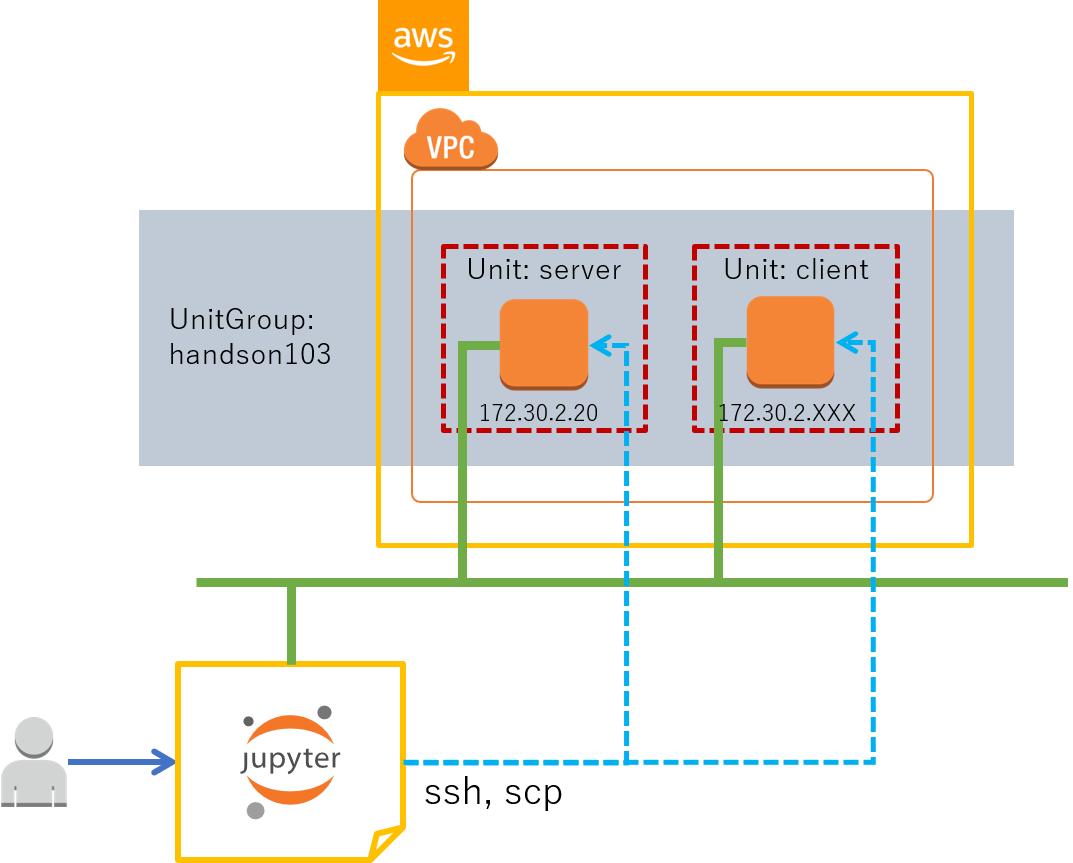

まずUnitGroupの全てのVCノードのIPアドレスを取得して変数 `ip_address`に格納します。

In [11]:
ip_address = unit_group.find_ip_addresses()

# 取得したIPアドレスを表示する
print(ip_address)

['172.30.2.20', '172.30.2.251']


sshを実行するときに指定するオプションを変数に設定しておきます。

> 指定しているオプションの意味については「[101-VCノードの起動、削除.ipynb](101-VCノードの起動、削除.ipynb#VCノードに-ssh-でログインして操作する)」を参照してください。

> 実運用では指定しないほうがよいオプションもあるので注意してください。

In [12]:
ssh_opts = "-i {} -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null -q".format(ssh_private_key)

`uname -a`, `df -h` をVCノードで実行してみます。

In [13]:
for address in ip_address:
    print(address + ':')
    !ssh {ssh_opts} root@{address} uname -a
    print()

172.30.2.20:
Linux ip-172-30-2-20 4.4.0-67-generic #88-Ubuntu SMP Wed Mar 8 16:34:45 UTC 2017 x86_64 Linux

172.30.2.251:
Linux ip-172-30-2-251 4.4.0-67-generic #88-Ubuntu SMP Wed Mar 8 16:34:45 UTC 2017 x86_64 Linux



In [14]:
for address in ip_address:
    print(address + ':')
    print('-' * 40)
    !ssh {ssh_opts} root@{address} df -h
    print()

172.30.2.20:
----------------------------------------
Filesystem                Size      Used Available Use% Mounted on
none                     19.6G      1.8G     16.8G  10% /
tmpfs                     3.9G         0      3.9G   0% /sys/fs/cgroup
udev                      3.9G         0      3.9G   0% /dev
tmpfs                    64.0M         0     64.0M   0% /dev/shm
/dev/xvda1               19.6G      1.8G     16.8G  10% /etc/resolv.conf
/dev/xvda1               19.6G      1.8G     16.8G  10% /etc/hostname
/dev/xvda1               19.6G      1.8G     16.8G  10% /etc/hosts
shm                      64.0M         0     64.0M   0% /dev/shm
/dev/xvda1               19.6G      1.8G     16.8G  10% /var/lib/docker
none                      3.9G         0      3.9G   0% /tmp
/dev/xvda1               19.6G      1.8G     16.8G  10% /var/lib/docker/aufs

172.30.2.251:
----------------------------------------
Filesystem                Size      Used Available Use% Mounted on
none            

scp コマンドでVCノードのファイル`/etc/os-release`をローカル環境に取得して、内容を表示させてみます。

In [15]:
import tempfile
import os

# 作業ディレクトリを作成
work_dir = tempfile.mkdtemp()

# VCノードのファイルをローカル環境にコピー
for address in ip_address:
    !mkdir -p {work_dir}/{address}
    !scp {ssh_opts} root@{server_ip_address}:/etc/os-release {work_dir}/{address}

# 取得したファイルを配置したディレクトリ構成を表示する
!tree {work_dir}
        
# 取得したファイルの内容を表示する
for address in ip_address:
    print(address + ':')
    print('-' * 40)
    !cat {os.path.join(work_dir, address, 'os-release')}
    print()

# 作業ディレクトリを削除
!rm -rf {work_dir}

/tmp/tmpw8fvxo_j
├── 172.30.2.20
│   └── os-release
└── 172.30.2.251
    └── os-release

2 directories, 2 files
172.30.2.20:
----------------------------------------
NAME="Alpine Linux"
ID=alpine
VERSION_ID=3.5.2
PRETTY_NAME="Alpine Linux v3.5"
HOME_URL="http://alpinelinux.org"
BUG_REPORT_URL="http://bugs.alpinelinux.org"

172.30.2.251:
----------------------------------------
NAME="Alpine Linux"
ID=alpine
VERSION_ID=3.5.2
PRETTY_NAME="Alpine Linux v3.5"
HOME_URL="http://alpinelinux.org"
BUG_REPORT_URL="http://bugs.alpinelinux.org"



# Ansibleを利用した VCノードの操作

前節で行った操作と同じことを Ansibleを用いて実行してみます。

## インベントリにVCノードを登録する

Ansibleを用いてホストの操作を行うためには、事前にそのホスト（IPアドレス）をAnsibleのインベントリに登録する必要があります。インベントリにホスト登録する方法はいくつかありますが、ここではINI形式のファイルに登録する方法を用います。INI形式のインベントリファイルは次のようなフォーマットになっています。

```
[group1]
host0

[group2]
host0
host1
host2
```

角括弧内の見出しはグループ名で、ホストの利用目的などで分類するために使用できます。`host0`のように一つのホストを複数のグループに所属させることもできます。

> インベントリの設定方法の詳細については[Ansibleのドキュメント - Working with Inventory](https://docs.ansible.com/ansible/latest/user_guide/intro_inventory.html)などを参照してください。

では、実際にインベントリファイルへの VCノード の登録を行います。ここでは、全てのVCノードを一つのグループに所属させるインベントリファイルを作成してみます。インベントリのグループ名は `handson103` とします。

次のセルを実行すると、カレントディレクトリにインベントリファイル`hosts`が作成されます。

In [16]:
# 次のようなファイルを作成する
# 
# [handson103]
# 172.30.2.20
# 172.30.2.xxx

with open('hosts', 'w') as f:
    f.write("[{}]\n".format(unit_group.name))   # グループ名を書き込む
    for addr in ip_address:                     # 取得済の VCノードのIPアドレスのリストで forループする
        f.write("{}\n".format(addr))            #  VCノードのIPアドレスを書き込む

# 作成したインベントリファイルの内容を表示する
!cat hosts

[handson103]
172.30.2.20
172.30.2.251


登録した VCノード をAnsible が操作対象と認識していることを確認するために `ansible` コマンドでホストの一覧を表示してみます。次のセルを実行すると`handson103`グループのホストを表示します。

In [17]:
!ansible handson103 --list-hosts -i ./hosts

  hosts (2):
    172.30.2.20
    172.30.2.251


`ansible` コマンドの実行方法と、上のセルで用いたオプションの簡単な説明を以下に記します。

```
ansible <ホストパターン> [オプション]

--list-hosts 
    ホストパターンにマッチするホストの一覧を表示する

-i INVENTORY
    インベントリのパスを指定する（デフォルト: /etc/ansible/hosts）
```

ホストパターンにはグループ名 `handson103` を指定したので、グループに属するホストが表示されます。

インベントリファイルのパスを毎回`-i`オプションで指定するのは煩雑なので、Ansible の設定ファイル`ansible.cfg`をカレントディレクトリに作成してインベントリのパスを設定します。

> Ansible の設定ファイルの記述方法については [Ansibleのドキュメント - The configuration file](https://docs.ansible.com/ansible/latest/reference_appendices/config.html)などを参照してください。

In [18]:
!chmod o-w .    # world-writable に設定されていると、カレントディレクトリの ansible.cfg を読み込まないので

if not os.path.exists('ansible.cfg'):
    # ansible.cfgが存在しない場合のみ作成する
    with open('ansible.cfg', 'w') as f:
        f.write('''[defaults]
inventory = {}
'''.format(os.path.abspath('./hosts')))

# 設定ファイルの内容を表示する
!cat ansible.cfg

[defaults]
inventory = /notebooks/notebook/handson/vcp-tutorial/hosts


先程と同じ`ansible`コマンドを`-i`オプション指定なしで実行して、インベントリファイルのパスの指定が不要になったことを確認してみます。

In [19]:
!ansible handson103 --list-hosts

  hosts (2):
    172.30.2.20
    172.30.2.251


Ansibleがリモートホストを操作する場合、通常 ssh でリモートホストに接続を行います。そのためsshで接続するためのパラメータ（ユーザ名、Identityファイルのパス、...）などを指定する必要があります。次に示すAnsibleの変数を設定することで、これらのsshの設定が行われます。

* ansible_user
  - リモートホストにsshで接続するためのユーザ名
* ansible_ssh_private_key_file
  - sshの秘密鍵ファイル
* ansible_ssh_extra_args
  - 設定した引数が常にsshコマンドラインに追加される
  
> 他の設定可能な変数については[Ansibleのドキュメント - List of Behavioral Inventory Parameters](https://docs.ansible.com/ansible/latest/user_guide/intro_inventory.html#list-of-behavioral-inventory-parameters)を参照してください。

Ansibleの変数を設定する方法はコマンドラインのオプション、インベントリファイルなど色々とありますが、ここでは変数用の YAML ファイルを作成してそこに値を格納します。変数のYAMLファイルはインベントリファイルのあるディレクトリからの相対パスで
```
group_vars/{グループ名}.yml
```
に配置します。

インベントリファイルはカレントディレクトリに置いてあるので`handson103`グループの変数ファイルは `./group_vars/handson103.yml`に配置します。次のセルを実行するとsshのパラメータを設定するための変数ファイルを作成します。

In [20]:
import yaml

# sshコマンドを実行したときと同等のパラメータを設定する
ansible_params = {
    'ansible_user': 'root',
    'ansible_ssh_private_key_file': os.path.abspath(ssh_private_key),
    
    # 次のパラメータは実運用では指定するべきではありません
    'ansible_ssh_extra_args': '-o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null',
}

!mkdir -p group_vars
vc_group_vars_path = os.path.abspath('group_vars/{}.yml'.format(unit_group.name))
# 変数ファイルのパスを表示する
print(vc_group_vars_path)

with open(vc_group_vars_path, 'w') as f:
    yaml.dump(ansible_params, stream=f, default_flow_style=False)   # YAML形式でファイルに ansiable_params を書き込む

# 変数ファイルの内容を表示する
!cat {vc_group_vars_path}

/notebooks/notebook/handson/vcp-tutorial/group_vars/handson103.yml
ansible_ssh_extra_args: -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null
ansible_ssh_private_key_file: /home/bit_kun/.ssh/id_rsa
ansible_user: root


## 疎通確認

VCノードに Ansible で接続できるかを確認します。

次のセルを実行してください。Ansibleでの接続に成功すると以下のような出力が表示されます。

```
172.30.2.XXX | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}
```

In [21]:
# グループ名をホストパターンに指定した場合
!ansible handson103 -m ping

172.30.2.251 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}
172.30.2.20 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}


上のセルで用いた`ansible`コマンドのオプションの簡単な説明を以下に記します。

```
ansible <ホストパターン> -m <モジュール名> [オプション]

-m MODULE_NAME
    実行するモジュールを指定する（デフォルト: command）
```

[ping モジュール](https://docs.ansible.com/ansible/latest/modules/ping_module.html)は、ホストパターンで指定したホストに Ansible が接続できるかをテストするモジュールです。

> IPの `ping`を行うのではなく、Ansibleに設定でリモートホストにsshで接続できるかをテストしています。

ホストパターンにはグループ名だけでなくインベントリに登録しているホスト名（IPアドレス）を指定することもできます。

In [22]:
# IPアドレスをホストパターンに指定した場合
!ansible 172.30.2.20 -m ping

172.30.2.20 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}


また、インベントリに登録されている全てのホストが所属している特別なグループ `all` を指定することもできます。

In [23]:
!ansible all -m ping

172.30.2.251 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}
172.30.2.20 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}


インベントリに登録していないホスト名を指定すると、以下のような警告メッセージが表示されます。マッチするホストがインベントリにないのでAnsibleによる操作が実行されません。
```
 [WARNING]: Could not match supplied host pattern, ignoring: 172.30.2.***

 [WARNING]: No hosts matched, nothing to do
```



In [24]:
# インベントリに登録していないホストを指定した場合
!ansible 172.30.2.200 -m ping

 [WARNING]: Could not match supplied host pattern, ignoring: 172.30.2.200

 [WARNING]: No hosts matched, nothing to do



## コマンドの実行

Ansibleを利用する準備ができたので、sshコマンドで行ったのと同様の操作を VCノードに対して実行してみます。

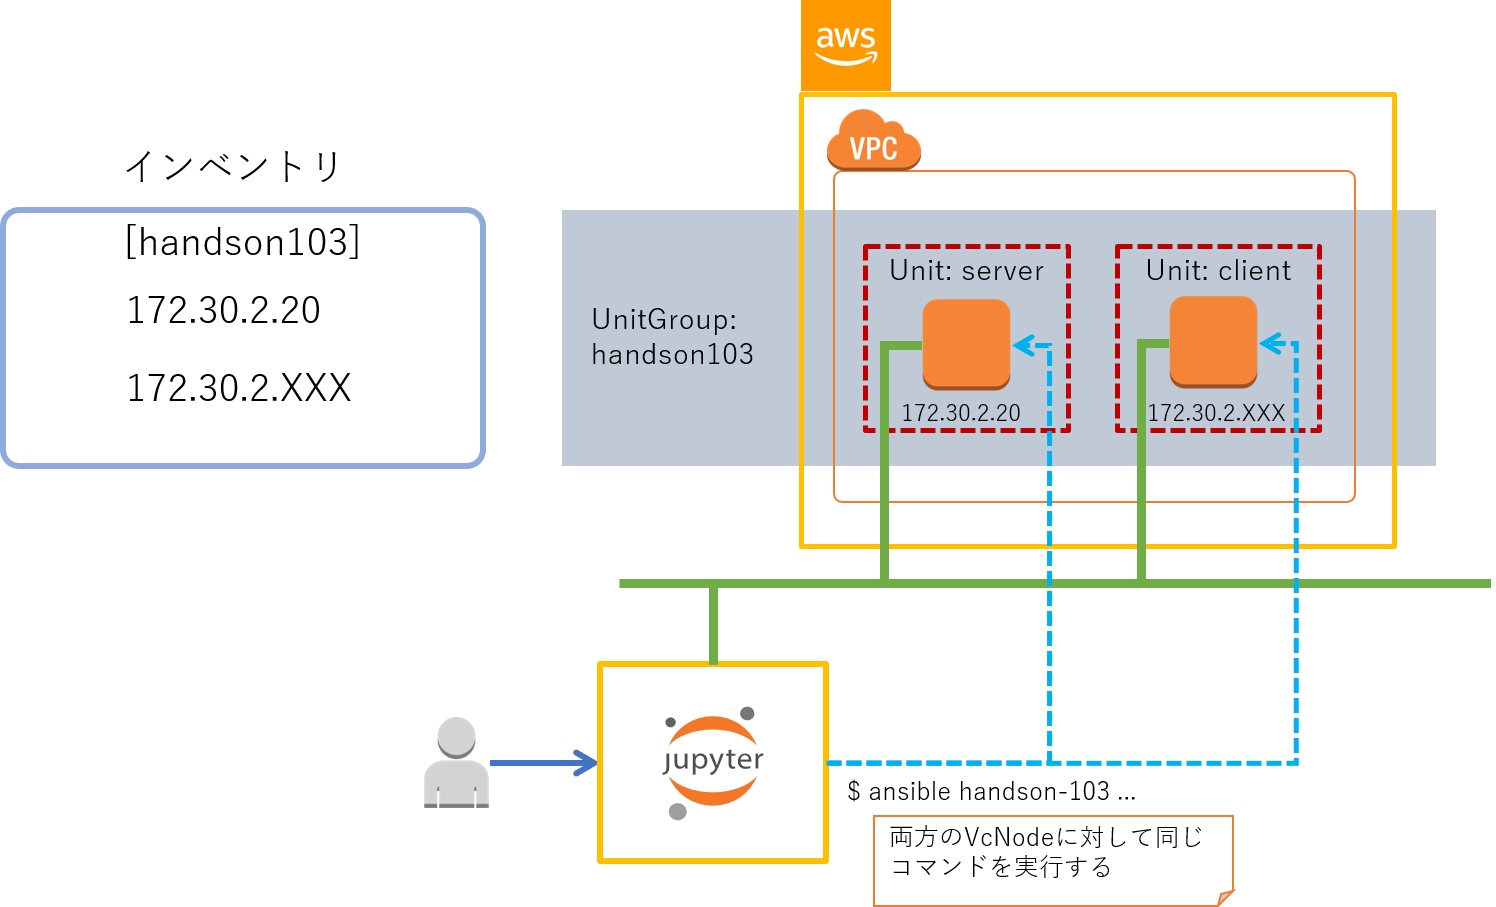

`ansible`を用いてリモート環境のコマンドを実行するには[command モジュール](https://docs.ansible.com/ansible/latest/modules/command_module.html)を利用します。簡単な使用方法を以下に示します。

```
ansible <ホストパターン> [-m command] -a <リモート環境で実行するコマンド>
```

`-m`オプションのデフォルト値は `command` なので `-m command`を省略することができます。

では実際に、VCノードに対して`uname -a`, `df -h` を実行してみます。

In [25]:
!ansible handson103 -a 'uname -a'
!ansible handson103 -a 'df -h'

172.30.2.251 | SUCCESS | rc=0 >>
Linux ip-172-30-2-251 4.4.0-67-generic #88-Ubuntu SMP Wed Mar 8 16:34:45 UTC 2017 x86_64 Linux

172.30.2.20 | SUCCESS | rc=0 >>
Linux ip-172-30-2-20 4.4.0-67-generic #88-Ubuntu SMP Wed Mar 8 16:34:45 UTC 2017 x86_64 Linux

172.30.2.251 | SUCCESS | rc=0 >>
Filesystem                Size      Used Available Use% Mounted on
none                     19.6G      1.8G     16.8G  10% /
tmpfs                     3.9G         0      3.9G   0% /sys/fs/cgroup
udev                      3.9G         0      3.9G   0% /dev
tmpfs                    64.0M         0     64.0M   0% /dev/shm
/dev/xvda1               19.6G      1.8G     16.8G  10% /etc/resolv.conf
/dev/xvda1               19.6G      1.8G     16.8G  10% /etc/hostname
/dev/xvda1               19.6G      1.8G     16.8G  10% /etc/hosts
shm                      64.0M         0     64.0M   0% /dev/shm
/dev/xvda1               19.6G      1.8G     16.8G  10% /var/lib/docker
none                      3.9G     56.0K  

sshコマンドで複数のVCノードを操作する場合はforループ処理を記述する必要がありましたが、Ansibleではその必要がありません。Ansibleでは操作対象の指定にグループ名が利用できるので、具体的なIPアドレスが変わった場合でもコマンドラインのパラメータを変更する必要がありません。

比較のために sshコマンド、Ansibleのそれぞれで `uname -a`を実行するためのコードを以下に示します。

sshコマンド:
```
ssh_opts = "-i {} -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null -q".format(ssh_private_key)
for address in ip_address:
    print(address + ':')
    !ssh {ssh_opts} root@{address} uname -a
    print()
```

Ansible:
```
!ansible handson103 -a 'uname -a'
```

Ansibleの場合、操作対象となるホストの情報はインベントリファイルに、sshのパラメータはAnsibleの変数ファイルに外出しされているので、簡潔な記述となります。

command モジュールはシェルによるコマンド実行ではないのでシェル変数やパイプ、リダイレクトなどは利用できません。パイプ、リダイレクトを利用したい場合は、[shellモジュール](https://docs.ansible.com/ansible/latest/modules/shell_module.html)を利用する必要があります。

In [26]:
!ansible handson103 -m shell -a "mount | grep -w /"

 [WARNING]: Consider using mount module rather than running mount

172.30.2.20 | SUCCESS | rc=0 >>
none on / type aufs (rw,relatime,si=f4929605bab8dbd5,dio,dirperm1)

172.30.2.251 | SUCCESS | rc=0 >>
none on / type aufs (rw,relatime,si=7cbebc2288d8f04e,dio,dirperm1)



## ファイルの取得

Ansibleを利用してVCノードのファイルをローカル環境に取得してみます。

リモート環境にあるファイルをローカル環境に取得するには[fetch モジュール](https://docs.ansible.com/ansible/latest/modules/fetch_module.html)を利用します。簡単な使用方法を以下に示します。

```
ansible <ホストパターン> -m fetch -a 'src=<取得元ファイルのパス> dest=<取得先となるディレクトリ>'

fetchモジュールのパラメータ(-a)について:
src
      取得元のリモート環境にあるファイルのパス
dest
      取得先となるローカル環境のディレクトリ
```

では、実際にリモート環境の `/etc/os-release` をローカル環境に取得してみます。

In [27]:
import tempfile

# 作業ディレクトリを作成
work_dir = tempfile.mkdtemp()

# Ansibleを利用してVCノードのファイルをローカル環境に取得する
!ansible handson103 -m fetch -a 'src=/etc/os-release dest={work_dir}'

# 取得したファイルを配置したディレクトリ構成を表示する
!tree {work_dir}
        
# 取得したファイルの内容を表示する
for address in ip_address:
    print(address + ':')
    print('-' * 40)
    !cat {os.path.join(work_dir, address, 'etc/os-release')}

# 作業ディレクトリを削除
!rm -rf {work_dir}

172.30.2.20 | SUCCESS => {
    "changed": true, 
    "checksum": "c6e0619046b498270ac737b51f1f869321e710f5", 
    "dest": "/tmp/tmpexbzvb7c/172.30.2.20/etc/os-release", 
    "failed": false, 
    "md5sum": "34b13b43513cad92a85bb8547f6fc5cb", 
    "remote_checksum": "c6e0619046b498270ac737b51f1f869321e710f5", 
    "remote_md5sum": null
}
172.30.2.251 | SUCCESS => {
    "changed": true, 
    "checksum": "c6e0619046b498270ac737b51f1f869321e710f5", 
    "dest": "/tmp/tmpexbzvb7c/172.30.2.251/etc/os-release", 
    "failed": false, 
    "md5sum": "34b13b43513cad92a85bb8547f6fc5cb", 
    "remote_checksum": "c6e0619046b498270ac737b51f1f869321e710f5", 
    "remote_md5sum": null
}
/tmp/tmpexbzvb7c
├── 172.30.2.20
│   └── etc
│       └── os-release
└── 172.30.2.251
    └── etc
        └── os-release

4 directories, 2 files
172.30.2.20:
----------------------------------------
NAME="Alpine Linux"
ID=alpine
VERSION_ID=3.5.2
PRETTY_NAME="Alpine Linux v3.5"
HOME_URL="http://alpinelinux.org"
BUG_REPOR

比較のために scpコマンド、Ansibleのそれぞれでリモート環境のファイルをローカル環境に取得するためのコードを以下に示します。

sshコマンド:
```
ssh_opts = "-i {} -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null -q".format(ssh_private_key)
for address in ip_address:
    !mkdir -p {work_dir}/{address}
    !scp {ssh_opts} root@{server_ip_address}:/etc/os-release {work_dir}/{address}
```

Ansible:
```
!ansible handson103 -m fetch -a 'src=/etc/os-release dest={work_dir}'
```

# Ansibleを利用した VCノードの操作（続き）

前節では以下のモジュールの利用例を示しました。

* [ping モジュール](https://docs.ansible.com/ansible/latest/modules/ping_module.html)
* [command モジュール](https://docs.ansible.com/ansible/latest/modules/command_module.html)
* [shellモジュール](https://docs.ansible.com/ansible/latest/modules/shell_module.html)
* [fetch モジュール](https://docs.ansible.com/ansible/latest/modules/fetch_module.html)

今節では、次のモジュールの利用例を示します。

* [packageモジュール](https://docs.ansible.com/ansible/latest/modules/package_module.html)
  - 汎用的なパッケージ操作を行う
* [copyモジュール](https://docs.ansible.com/ansible/latest/modules/copy_module.html)
  - ローカル環境のファイルをリモート環境に配置する
* [synchronizeモジュール](https://docs.ansible.com/ansible/latest/modules/synchronize_module.html)
  - rsyncのラッパーモジュール。リモート環境への再帰的なファイル配置を行う場合は copy モジュールよりも適している。

また、インベントリにグループの階層（グループのグループ）を作成する方法についてもふれます。

## パッケージのインストール

VCノードでCPUに関する情報を表示する`lscpu` コマンドを実行してみます。

In [28]:
!ansible handson103 -a 'lscpu'

172.30.2.20 | FAILED | rc=2 >>
[Errno 2] No such file or directory

172.30.2.251 | FAILED | rc=2 >>
[Errno 2] No such file or directory



RuntimeError: Unexpected exit code: 2

VCノードに `lscpu`コマンドがインストールされていないのでエラーになります。そこで Ansible を利用して `lscpu`コマンドのインストールを行います。

今回起動している VCノードは Alpine Linux 環境です。Alpine Linux では `lscpu`コマンドが `util-linux`というパッケージに[含まれています](https://pkgs.alpinelinux.org/contents?file=lscpu&path=&name=util-linux&branch=v3.5&repo=main&arch=x86)。そこで Ansible で `util-linux` パッケージのインストールを行います。

Ansible の[パッケージに関するモジュール](https://docs.ansible.com/ansible/latest/modules/list_of_packaging_modules.html)は色々とありますが、今回は汎用的なパッケージ操作を行う[packageモジュール](https://docs.ansible.com/ansible/latest/modules/package_module.html)を利用します。簡単な使用方法を以下に記します。

```
ansible <ホストパターン> -b -m package -a 'name=<パッケージ名>'

-b
    管理者権限で操作を実行する
    
packageモジュールのパラメータ(-a)について:
name
      操作対象のパッケージ名
      複数指定する場合はカンマ(,)で区切る
```

In [29]:
!ansible handson103 -b -m package -a 'name=util-linux'

172.30.2.20 | SUCCESS => {
    "changed": true, 
    "failed": false, 
    "msg": "installed util-linux package(s)", 
    "packages": [
        "libsmartcols", 
        "findmnt", 
        "libfdisk", 
        "util-linux"
    ], 
    "stderr": "", 
    "stderr_lines": [], 
    "stdout": "(1/4) Installing libsmartcols (2.28.2-r1)\n(2/4) Installing findmnt (2.28.2-r1)\n(3/4) Installing libfdisk (2.28.2-r1)\n(4/4) Installing util-linux (2.28.2-r1)\nExecuting busybox-1.25.1-r0.trigger\nOK: 144 MiB in 101 packages\n", 
    "stdout_lines": [
        "(1/4) Installing libsmartcols (2.28.2-r1)", 
        "(2/4) Installing findmnt (2.28.2-r1)", 
        "(3/4) Installing libfdisk (2.28.2-r1)", 
        "(4/4) Installing util-linux (2.28.2-r1)", 
        "Executing busybox-1.25.1-r0.trigger", 
        "OK: 144 MiB in 101 packages"
    ]
}
172.30.2.251 | SUCCESS => {
    "changed": true, 
    "failed": false, 
    "msg": "installed util-linux package(s)", 
    "packages": [
        "libsmartcols

`lscpu` を実行してみます。今度は `lscpu` が実行できるはずです。

In [30]:
!ansible handson103 -a 'lscpu'

172.30.2.251 | SUCCESS | rc=0 >>
Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                2
On-line CPU(s) list:   0,1
Thread(s) per core:    2
Core(s) per socket:    1
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
Stepping:              1
CPU MHz:               2300.072
BogoMIPS:              4600.14
Hypervisor vendor:     Xen
Virtualization type:   full
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              46080K
NUMA node0 CPU(s):     0,1
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology eagerfpu pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadl

複数のパッケージをインストールする場合はカンマで区切ってパッケージ名を列挙します。

In [31]:
!ansible handson103 -b -m package -a 'name=rsync,tree,netcat-openbsd'

172.30.2.20 | SUCCESS => {
    "changed": true, 
    "failed": false, 
    "msg": "installed rsync tree netcat-openbsd package(s)", 
    "packages": [
        "libintl", 
        "pcre", 
        "glib", 
        "netcat-openbsd", 
        "libattr", 
        "libacl", 
        "popt", 
        "rsync", 
        "tree"
    ], 
    "stderr": "", 
    "stderr_lines": [], 
    "stdout": "(1/9) Installing libintl (0.19.8.1-r0)\n(2/9) Installing pcre (8.39-r0)\n(3/9) Installing glib (2.50.2-r0)\n(4/9) Installing netcat-openbsd (1.89-r2)\n(5/9) Installing libattr (2.4.47-r4)\n(6/9) Installing libacl (2.2.52-r2)\n(7/9) Installing popt (1.16-r6)\n(8/9) Installing rsync (3.1.3-r0)\n(9/9) Installing tree (1.7.0-r0)\nExecuting busybox-1.25.1-r0.trigger\nExecuting glib-2.50.2-r0.trigger\nOK: 148 MiB in 110 packages\n", 
    "stdout_lines": [
        "(1/9) Installing libintl (0.19.8.1-r0)", 
        "(2/9) Installing pcre (8.39-r0)", 
        "(3/9) Installing glib (2.50.2-r0)", 
        "(4/9) In

## グループの階層

Ansibleのグループは階層構造をもつことができます。

現在のインベントリでは`handson103`というVCに対応するグループのみ定義しています。これを変更してUnit:`server`, Unit:`client`に対応するグループを定義して、さらにその親グループとして`handson103`を定義し直します。

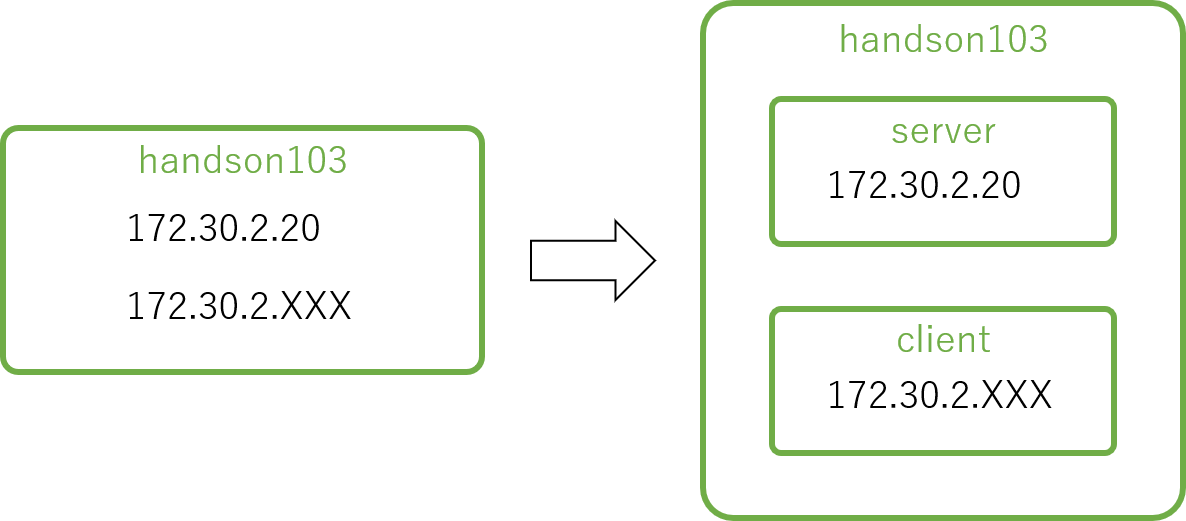

こうすることでVCP SDKの UnitGroup, Unit と同じ構造をAnsibleのグループとして定義することができます。

### インベントリの更新

グループの階層（グループのグループ）を定義するには、インベントリに角括弧内の見出しのサフィックスに`:children`を付けます。

```
[group1:children]
group2
group3
```

上の例では group2, group3 が group1の子グループになります。

> 詳細については[Ansibleのドキュメント - Groups of Groups, and Group Variables](https://docs.ansible.com/ansible/latest/user_guide/intro_inventory.html#groups-of-groups-and-group-variables)などを参照してください。

次のセルを実行するとカレントディレクトリのインベントリファイルを更新します。

In [32]:
with open('hosts', 'w') as f:
    for unit in unit_group.find_units():
        f.write("[{}]\n".format(unit.name))                      # Unit名をグループ名にする
        for addr in unit.find_ip_addresses():                    # Unitに属しているVCノードのリストを取得する
            f.write("{}\n".format(addr))                         # VCノードのIPアドレスをインベントリ書き込む
        f.write("\n")
    f.write("[{}:children]\n".format(unit_group.name))           # グループのグループ定義。名前は VC名にする
    for unit in unit_group.find_units():
        f.write("{}\n".format(unit.name))                        # 所属するグループ名を書き込む

# インベントリの内容を表示する
!cat hosts

[server]
172.30.2.20

[client]
172.30.2.251

[handson103:children]
server
client


### Ansibleコマンドの実行

新たに定義したグループ`server`, `client` をホストパターンに指定できることを確認します。

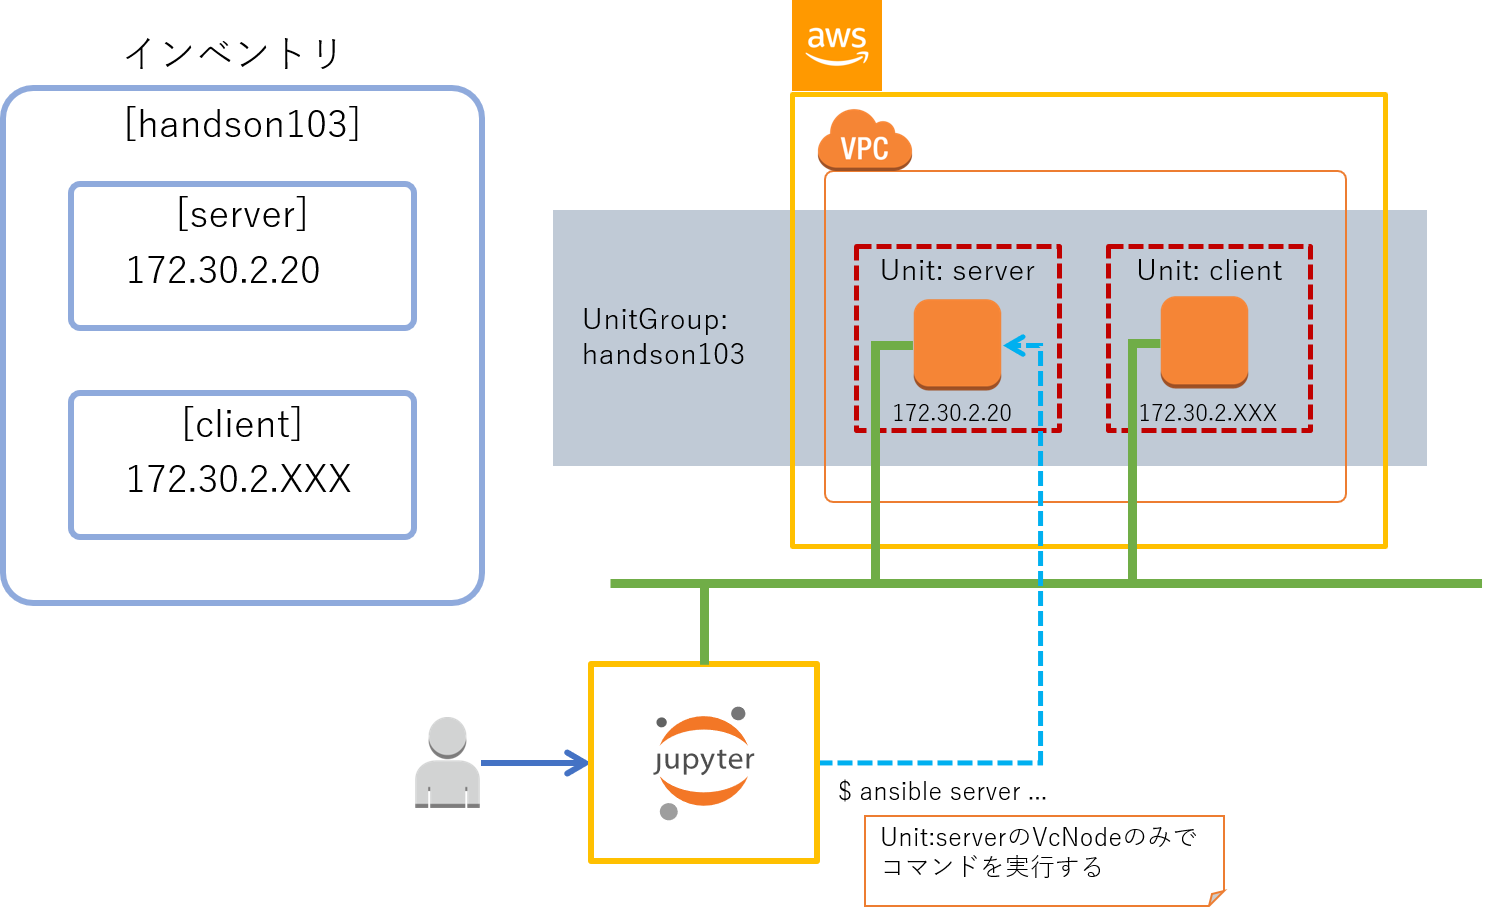

In [33]:
!ansible server -m ping

172.30.2.20 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}


In [34]:
!ansible client -m ping

172.30.2.251 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}


グループのグループ`handson103`を指定すると `server`, `client` の両方のVCノードに対して操作できることを確認します。

In [35]:
!ansible handson103 -m ping

172.30.2.20 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}
172.30.2.251 | SUCCESS => {
    "changed": false, 
    "failed": false, 
    "ping": "pong"
}


## VCノードへのファイルの配置

### copyモジュール

ローカル環境のファイルをリモート環境に配置するには[copyモジュール](https://docs.ansible.com/ansible/latest/modules/copy_module.html)を利用します。簡単な使用方法を以下に示します。

```
ansible <ホストパターン> [-b] -m copy -a 'src=<元ファイル> dest=<配置先>'

-b
    管理者権限で操作を実行する
    
copyモジュールのパラメータ(-a)について:
src
      配置元となるローカル環境のファイル
dest
      配置先となるリモート環境のパス
```

実際に[copyモジュール](https://docs.ansible.com/ansible/latest/modules/copy_module.html)を利用して、ローカル環境にあるVCPSDK API仕様書のhtmlファイルを server UnitのVCノードに配置してみます。

In [36]:
# !ansible server -b -m file -a 'path=/opt/DOC/ state=directory'   #　次の文と同じ操作となる
!ansible server -b -a 'mkdir -p /opt/DOC/'

# ファイルの配置を行う
!ansible server -b -m copy -a 'src=/notebooks/notebook/DOC/index.html dest=/opt/DOC/'

 [WARNING]: Consider using file module with state=directory rather than running
mkdir

172.30.2.20 | SUCCESS | rc=0 >>


172.30.2.20 | SUCCESS => {
    "changed": true, 
    "checksum": "3787893709964e3da1ef53289c69850b8ba42382", 
    "dest": "/opt/DOC/index.html", 
    "failed": false, 
    "gid": 0, 
    "group": "root", 
    "md5sum": "fb232c05541d075a6a4df0c07cf8904b", 
    "mode": "0644", 
    "owner": "root", 
    "size": 164896, 
    "src": "/root/.ansible/tmp/ansible-tmp-1538115872.31-121907729985167/source", 
    "state": "file", 
    "uid": 0
}


VCノードにファイルが配置されたことを確認します。

In [37]:
!ansible server -a 'tree /opt/DOC'

172.30.2.20 | SUCCESS | rc=0 >>
/opt/DOC
└── index.html

0 directories, 1 file



### synchronizeモジュール

copyモジュールではHTMLファイルのみをVCノードに配置しました。次に、画像ファイルやスタイルシートなど含めたソースツリー全体をリモート環境に配置してみます。

ローカル環境にあるディレクトリ階層をリモート環境に配置する場合は [synchronizeモジュール](https://docs.ansible.com/ansible/latest/modules/synchronize_module.html)を利用します。

In [38]:
!ansible server -m synchronize -a 'src=/notebooks/notebook/DOC/ dest=/opt/DOC/'

172.30.2.20 | SUCCESS => {
    "changed": true, 
    "cmd": "/usr/bin/rsync --delay-updates -F --compress --archive --rsh=/usr/bin/ssh -S none -i /home/bit_kun/.ssh/id_rsa -o StrictHostKeyChecking=no -o UserKnownHostsFile=/dev/null --out-format=<<CHANGED>>%i %n%L /notebooks/notebook/DOC/ root@172.30.2.20:/opt/DOC/", 
    "failed": false, 
    "msg": ".d..t.og... ./\n<f..t.og... index.html\ncd+++++++++ _images/\n<f+++++++++ _images/disk_state.png\n<f+++++++++ _images/node_state.png\n<f+++++++++ _images/vc_state.png\n<f+++++++++ _images/vcp_structure.png\ncd+++++++++ _static/\n<f+++++++++ _static/ajax-loader.gif\n<f+++++++++ _static/basic.css\n<f+++++++++ _static/comment-bright.png\n<f+++++++++ _static/comment-close.png\n<f+++++++++ _static/comment.png\n<f+++++++++ _static/doctools.js\n<f+++++++++ _static/down-pressed.png\n<f+++++++++ _static/down.png\n<f+++++++++ _static/file.png\n<f+++++++++ _static/jquery.js\n<f+++++++++ _static/minus.png\n<f+++++++++ _static/plus.png\n<f+++++++++ _st

VCノードにファイルが配置されたことを確認します。

In [39]:
!ansible server -a 'tree /opt/DOC'

172.30.2.20 | SUCCESS | rc=0 >>
/opt/DOC
├── _images
│   ├── disk_state.png
│   ├── node_state.png
│   ├── vc_state.png
│   └── vcp_structure.png
├── _static
│   ├── ajax-loader.gif
│   ├── basic.css
│   ├── comment-bright.png
│   ├── comment-close.png
│   ├── comment.png
│   ├── css
│   │   ├── badge_only.css
│   │   └── theme.css
│   ├── doctools.js
│   ├── down-pressed.png
│   ├── down.png
│   ├── file.png
│   ├── fonts
│   │   ├── Inconsolata-Bold.ttf
│   │   ├── Inconsolata-Regular.ttf
│   │   ├── Lato
│   │   │   ├── lato-bold.eot
│   │   │   ├── lato-bold.ttf
│   │   │   ├── lato-bold.woff
│   │   │   ├── lato-bold.woff2
│   │   │   ├── lato-bolditalic.eot
│   │   │   ├── lato-bolditalic.ttf
│   │   │   ├── lato-bolditalic.woff
│   │   │   ├── lato-bolditalic.woff2
│   │   │   ├── lato-italic.eot
│   │   │   ├── lato-italic.ttf
│   │   │   ├── lato-italic.woff
│   │   │   ├── lato-italic.woff2
│   │   │   ├── lato-regular.eot
│   │   │   ├── lato-regular.ttf
│   │   │   ├── lato

# 後始末

不要になった UnitGroup を削除します。

> 処理が完了するまで2分半～3分程度かかります。

In [40]:
unit_group.cleanup()

2018-09-28 15:24:49,665 - INFO - server is DELETING
client is DELETING ... 0 sec
2018-09-28 15:24:54,939 - INFO - server is DELETING
client is DELETING ... 5 sec
2018-09-28 15:25:00,231 - INFO - server is DELETING
client is DELETING ... 10 sec
2018-09-28 15:25:05,514 - INFO - server is DELETING
client is DELETING ... 15 sec
2018-09-28 15:25:10,797 - INFO - server is DELETING
client is DELETING ... 20 sec
2018-09-28 15:25:16,088 - INFO - server is DELETING
client is DELETING ... 25 sec
2018-09-28 15:25:21,374 - INFO - server is DELETING
client is DELETING ... 30 sec
2018-09-28 15:25:26,659 - INFO - server is DELETING
client is DELETING ... 35 sec
2018-09-28 15:25:31,940 - INFO - server is DELETING
client is DELETING ... 40 sec
2018-09-28 15:25:37,224 - INFO - server is DELETING
client is DELETING ... 45 sec
2018-09-28 15:25:42,465 - INFO - client is DELETING ... 50 sec
2018-09-28 15:25:47,715 - INFO - client is DELETING ... 55 sec
2018-09-28 15:25:52,955 - INFO - client is DELETING ... 

不要になったインベントリファイルを削除します。

In [41]:
!rm hosts